In [1]:
%config Completer.use_jedi = False

In [2]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from matplotlib import pyplot as plt
import math
import os
import random
import sys
from functools import partial, reduce
from scipy.optimize import fmin_tnc
import itertools
import random
import tqdm
from typing import*
from collections import*
from scipy import*
from sklearn.metrics import*
from numpy import *
import random
from itertools import cycle
from sklearn import*
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import collections


In [3]:
# Functions

# def add(a, b): return a + b

Vector = List[float]

Tensor = list

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

#     return np.sum(v_i * w_i for v_i, w_i in zip(v, w))
#     gen = 
    return np.sum(np.fromiter((v_i * w_i for v_i, w_i in zip(v, w)),float))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = data.shape[0]
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = data.shape[0]
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                
def step_function(x: float) -> float:
    return 1.0 if x >= 0 else 0.0

def sigmoid(t: float) -> float: 
    return 1 / (1 + math.exp(-t))

# Gradient Descent - step
def gradient_step(v: Vector, gradient: Vector, step_size: float):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def sum_of_squares_gradient(v: Vector) -> Vector:
    return [2 * v_i for v_i in v]

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensional (that is, a vector).
    """
    return not isinstance(tensor[0], list)

def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise""" 
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor] 
    
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)


def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]
    
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the CDF's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2


def num_differences(v1, v2):
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])


def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]


class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")
                
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the
inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

def recolor(pixel):
    cluster = clusterer.classify(pixel)        # index of the closest cluster
    return clusterer.means[cluster]            # mean of the closest cluster

def get_values(cluster):
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]


def cluster_distance(cluster1,
                     cluster2,
                     distance_agg: Callable = min):
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting
list
    """
    return distance_agg([distance(v1, v2) for v1 in get_values(cluster1) for v2 in get_values(cluster2)])

def get_merge_order(cluster):
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order
    
def get_children(cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children
    
class Merged(NamedTuple):
    children: tuple
    order: int
        
class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min):
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair):
        return cluster_distance(pair[0], pair[1], distance_agg)
 
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2) 
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

def generate_clusters(base_cluster,
                      num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters


def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: Vector):
    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points, key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

# class LabeledPoint(NamedTuple):
#     point: Vector
#     label: str
 
    
# Functions

# def add(a, b): return a + b

Vector = List[float]

Tensor = list

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

#     return np.sum(v_i * w_i for v_i, w_i in zip(v, w))
#     gen = 
    return np.sum(np.fromiter((v_i * w_i for v_i, w_i in zip(v, w)),float))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = data.shape[0]
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = data.shape[0]
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                
def step_function(x: float) -> float:
    return 1.0 if x >= 0 else 0.0

def sigmoid(t: float) -> float: 
    return 1 / (1 + math.exp(-t))

# Gradient Descent - step
def gradient_step(v: Vector, gradient: Vector, step_size: float):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def sum_of_squares_gradient(v: Vector) -> Vector:
    return [2 * v_i for v_i in v]

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensional (that is, a vector).
    """
    return not isinstance(tensor[0], list)

def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise""" 
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor] 
    
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)


def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]
    
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the CDF's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2


def num_differences(v1, v2):
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])


def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]


class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")
                
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the
inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

def recolor(pixel):
    cluster = clusterer.classify(pixel)        # index of the closest cluster
    return clusterer.means[cluster]            # mean of the closest cluster

def get_values(cluster):
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]


def cluster_distance(cluster1,
                     cluster2,
                     distance_agg: Callable = min):
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting
list
    """
    return distance_agg([distance(v1, v2) for v1 in get_values(cluster1) for v2 in get_values(cluster2)])

def get_merge_order(cluster):
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order
    
def get_children(cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children
    
class Merged(NamedTuple):
    children: tuple
    order: int

def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min):
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair):
        return cluster_distance(pair[0], pair[1], distance_agg)
 
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2) 
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

def generate_clusters(base_cluster,
                      num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [4]:
class LogisticRegressionCustom(object):
    def __init__(self, eta=0.01, n_iter=10000):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
#         self.w = np.ones(X.shape[1])
        self.w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        m = X.shape[0]

        for _ in range(self.n_iter):
            output = X.dot(self.w)
            errors = y - self._sigmoid(output)
            self.w += self.eta / m * errors.dot(X)
        return self

    def predict(self, X):
        output = np.insert(X, 0, 1, axis=1).dot(self.w)
        return (np.floor(self._sigmoid(output) + .5)).astype(int)

    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [5]:
def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

In [6]:
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest
 

In [7]:
from typing import NamedTuple
# from vector_operations import Vector, distance

class LabeledPoint(NamedTuple):
    point: Vector
    label: str
        
def knn_classify(k: int,
                labeled_points: List[Vector],
                new_point: Vector) -> str:
    # Order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points, 
                         key = lambda lp: distance(lp.point, new_point))
    
    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    

    
    # and let them vote
    return majority_vote(k_nearest_labels)

In [8]:
# import requests

# data = requests.get("https://archive.ics.uci.edu/ml/machine-learningdatabases/iris/iris.data")

# with open('iris.data', 'w') as f:
#     f.write(data.text)

In [9]:
# Example on the iris dataset
import requests
data = requests.get(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('iris.csv','w') as f:
    f.write(data.text)
# data.text

In [10]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """sepal length, sepal width, petal length, petal width, class"""
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica", we just want "virginica"
    label = row[-1].split("-")[-1]
    return LabeledPoint(measurements, label)

In [11]:
# from typing import Dict
# import csv
# from collections import defaultdict

# def parse_iris_row(row: List[str]) -> LabeledPoint:
#     """
#     sepal_length, sepal_width, petal_length, petal_width, class
#     """
#     measurements = [float(value) for value in row[:-1]]
#     # class is e.g. "Iris-virginica"; we just want "virginica"
#     label = row[-1].split("-")[-1]

#     return LabeledPoint(measurements, label)



In [12]:
with open('iris.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    iris_data = []
    for row in csv_reader:
        iris_data.append(row)
    print(f'Processed {line_count} lines.')

iris_data = iris_data[:-2]

iris_data = [parse_iris_row(row) for row in iris_data]

Processed 0 lines.


In [13]:
# group the points by species for plotting
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)
    

In [14]:
# with open('iris.data') as f:
#     reader = csv.reader(f)
#     iris_data = [parse_iris_row(row) for row in reader]
    
# # We'll also group just the points by species/label so we can plot them
# points_by_species: Dict[str, List[Vector]] = defaultdict(list)
# for iris in iris_data:
#     points_by_species[iris.label].append(iris.point)


 


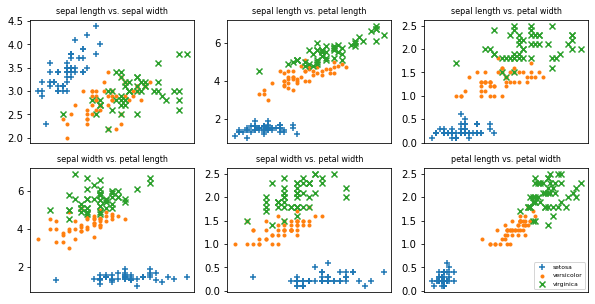

In [15]:
import matplotlib.pyplot as plt
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i,j) for i in range(4) for j in range(4) if i < j]
marks = ['+','.','x'] # 3 markers for our 3 classes

fig, ax = plt.subplots(2,3, figsize=(10, 5))

for row in range(2):
    for col in range(3):
        i, j = pairs[3*row + col]
        ax[row][col].set_title(f"{metrics[i]} vs. {metrics[j]}", fontsize = 8)
        ax[row][col].set_xticks([])
        ax[row][col].set_xticks([])
        
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs,ys, marker = mark, label = species)
            
ax[-1][-1].legend(loc = 'lower right', prop = {'size':6})
plt.show()

In [16]:
random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
# assert len(iris_train) == 0.7 * 150
# assert len(iris_test) == 0.3 * 150


In [17]:
from typing import Tuple
 
# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

1.0 defaultdict(<class 'int'>, {('versicolor', 'versicolor'): 16, ('setosa', 'setosa'): 13, ('virginica', 'virginica'): 16})


In [18]:
def random_point(dim: int) -> Vector:
     return [random.random() for _ in range(dim)]


In [19]:
def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]



In [20]:
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum

Curse of Dimensionality: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11it/s]


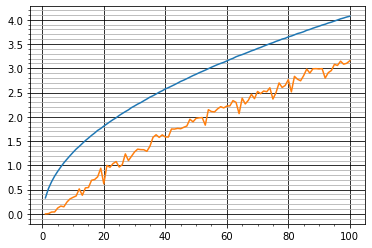

In [21]:
plt.plot(dimensions,avg_distances, dimensions,min_distances)
plt.grid()
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')
plt.show()

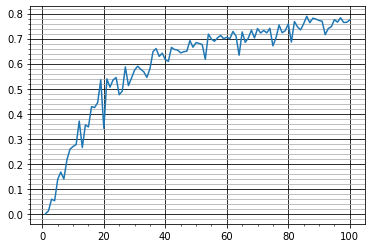

In [22]:
min_avg_ratio = [min_dist / avg_dist
                 for min_dist, avg_dist in zip(min_distances,
avg_distances)]

plt.plot(dimensions,min_avg_ratio)
plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')
plt.show()